In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate

from datetime import datetime
from IPython.display import SVG, HTML, display
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras_lr_finder import LRFinder
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
_file = pd.ExcelFile("./Mucuri_novo_semNaN_torre150m.xlsx")
df = _file.parse("Dados anemo")

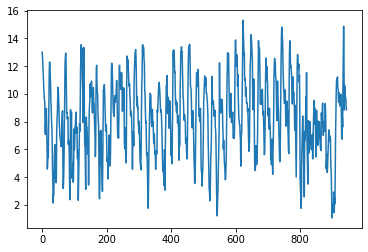

In [3]:
plt.plot(df.v_anemo2)
plt.show()

In [4]:
train_data_1 = df[pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=22)]
train_data_2 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] <= 11)
]

X_train_data = pd.concat([train_data_1, train_data_2]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [5]:
test_data_1 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] >= 12)
]
test_data_2 = df[
    (pd.to_datetime(df["Data"]) >= datetime(year=2015, month=12, day=24))
    & (pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=30))
]
test_data_3 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=31))
    & (df["hora"] <= 13)
]

X_test_data = pd.concat([test_data_1, test_data_2, test_data_3]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [6]:
def generate_Y(X, number_of_hours=1):
    
    X = X.copy()
    
    try:
        Y = X.v_anemo2
    except:
        Y = X[:,0]

    Y = Y[number_of_hours:]
    X = X[:len(X)-number_of_hours]
    
    return X, Y

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.fit_transform(X_test_data)

In [8]:
X_train, Y_train = generate_Y(X_train_data)

In [9]:
X_test, Y_test = generate_Y(X_test_data)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 5))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 5))

In [11]:
class MucuriModelLSTM:
    
    def __init__(self):
        
        self.model = None
        self._build_model()
        
    def _build_model(self):
        
        if self.model is None:
            
            self.model = Sequential()
            self.model.add(LSTM(4, input_shape=(1, 5)))
            self.model.add(Dense(1))
            self.model.compile(loss="mean_squared_error", optimizer=Adam(0.013), metrics=["mse", "mae"])
            
    def train(self, X, Y, X_test=None, Y_test=None, epochs=50, verbose=0):
        
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test) if X_test is not None and Y_test is not None else None,
            verbose=verbose,
            batch_size=64,
            epochs=epochs,
        )
    
    def predict(self, X):
        
        return self.model.predict(X)

In [12]:
model = MucuriModelLSTM()

In [13]:
# %%capture

lr_finder = LRFinder(model.model)
lr_finder.find(X_train, Y_train, start_lr=0.01, end_lr=0.015, epochs=300)

Epoch 1/300
549/549 [==============================] - 0s 476us/step - loss: 0.2726 - mse: 0.2726 - mae: 0.4609
Epoch 2/300
549/549 [==============================] - 0s 25us/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1915
Epoch 3/300
549/549 [==============================] - 0s 39us/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1901
Epoch 4/300
549/549 [==============================] - 0s 31us/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1660
Epoch 5/300
549/549 [==============================] - 0s 31us/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1545
Epoch 6/300
549/549 [==============================] - 0s 32us/step - loss: 0.0340 - mse: 0.0340 - mae: 0.1506
Epoch 7/300
549/549 [==============================] - 0s 25us/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1431
Epoch 8/300
549/549 [==============================] - 0s 26us/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1392
Epoch 9/300
549/549 [==============================] - 0s 27us/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1349


549/549 [==============================] - 0s 24us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0715
Epoch 75/300
549/549 [==============================] - 0s 22us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0714
Epoch 76/300
549/549 [==============================] - 0s 25us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0714
Epoch 77/300
549/549 [==============================] - 0s 20us/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0719
Epoch 78/300
549/549 [==============================] - 0s 22us/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0722
Epoch 79/300
549/549 [==============================] - 0s 23us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0712
Epoch 80/300
549/549 [==============================] - 0s 22us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0711
Epoch 81/300
549/549 [==============================] - 0s 21us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0710
Epoch 82/300
549/549 [==============================] - 0s 20us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0711
Epoch

549/549 [==============================] - 0s 21us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0703
Epoch 147/300
549/549 [==============================] - 0s 24us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0707
Epoch 148/300
549/549 [==============================] - 0s 23us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0704
Epoch 149/300
549/549 [==============================] - 0s 21us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0704
Epoch 150/300
549/549 [==============================] - 0s 21us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0702
Epoch 151/300
549/549 [==============================] - 0s 23us/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0698
Epoch 152/300
549/549 [==============================] - 0s 22us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0698
Epoch 153/300
549/549 [==============================] - 0s 22us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0700
Epoch 154/300
549/549 [==============================] - 0s 20us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.07

549/549 [==============================] - 0s 21us/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0686
Epoch 219/300
549/549 [==============================] - 0s 25us/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0683
Epoch 220/300
549/549 [==============================] - 0s 22us/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0680
Epoch 221/300
549/549 [==============================] - 0s 20us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0673
Epoch 222/300
549/549 [==============================] - 0s 21us/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0678
Epoch 223/300
549/549 [==============================] - 0s 22us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0672
Epoch 224/300
549/549 [==============================] - 0s 22us/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0686
Epoch 225/300
549/549 [==============================] - 0s 22us/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0697
Epoch 226/300
549/549 [==============================] - 0s 18us/step - loss: 0.0076 - mse: 0.0076 - mae: 0.06

549/549 [==============================] - 0s 24us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0669
Epoch 291/300
549/549 [==============================] - 0s 25us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0672
Epoch 292/300
549/549 [==============================] - 0s 23us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0664
Epoch 293/300
549/549 [==============================] - 0s 22us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0667
Epoch 294/300
549/549 [==============================] - 0s 21us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0658
Epoch 295/300
549/549 [==============================] - 0s 23us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0657
Epoch 296/300
549/549 [==============================] - 0s 22us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0665
Epoch 297/300
549/549 [==============================] - 0s 22us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0667
Epoch 298/300
549/549 [==============================] - 0s 21us/step - loss: 0.0071 - mse: 0.0071 - mae: 0.06

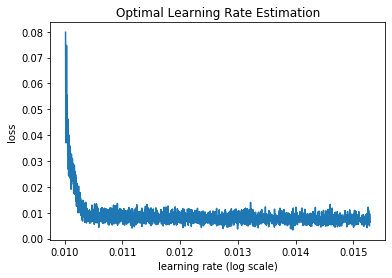

In [14]:
lr_finder.plot_loss()
plt.title(f"Optimal Learning Rate Estimation")
plt.xscale('linear')
plt.show()

In [15]:
training_history = model.train(X_train, Y_train, X_test, Y_test, epochs=100, verbose=1)

Train on 549 samples, validate on 193 samples
Epoch 1/100
549/549 [==============================] - 0s 101us/step - loss: 0.1579 - mse: 0.1579 - mae: 0.3190 - val_loss: 0.1424 - val_mse: 0.1424 - val_mae: 0.3252
Epoch 2/100
549/549 [==============================] - 0s 22us/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1858 - val_loss: 0.0424 - val_mse: 0.0424 - val_mae: 0.1700
Epoch 3/100
549/549 [==============================] - 0s 26us/step - loss: 0.0392 - mse: 0.0392 - mae: 0.1616 - val_loss: 0.0697 - val_mse: 0.0697 - val_mae: 0.2195
Epoch 4/100
549/549 [==============================] - 0s 31us/step - loss: 0.0353 - mse: 0.0353 - mae: 0.1494 - val_loss: 0.0447 - val_mse: 0.0447 - val_mae: 0.1765
Epoch 5/100
549/549 [==============================] - 0s 29us/step - loss: 0.0288 - mse: 0.0288 - mae: 0.1393 - val_loss: 0.0416 - val_mse: 0.0416 - val_mae: 0.1700
Epoch 6/100
549/549 [==============================] - 0s 28us/step - loss: 0.0242 - mse: 0.0242 - mae: 0.1252 - val_loss: 

Epoch 50/100
549/549 [==============================] - 0s 22us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0714 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.1036
Epoch 51/100
549/549 [==============================] - 0s 23us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0716 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.1001
Epoch 52/100
549/549 [==============================] - 0s 20us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0712 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.1067
Epoch 53/100
549/549 [==============================] - 0s 21us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0718 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0995
Epoch 54/100
549/549 [==============================] - 0s 22us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0718 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.1006
Epoch 55/100
549/549 [==============================] - 0s 21us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0712 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.107

549/549 [==============================] - 0s 26us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0705 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.1036
Epoch 100/100
549/549 [==============================] - 0s 25us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0707 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0946


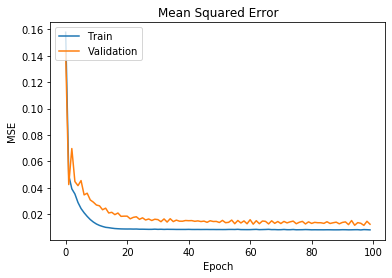

In [16]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

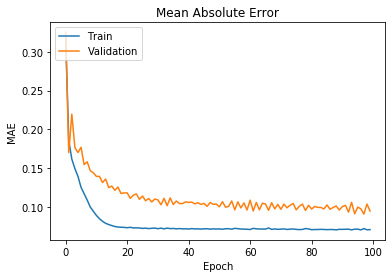

In [17]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title("Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [18]:
def predict(X, number_of_hours):
  
    assert number_of_hours > 0

    result = None
    input_data = X.copy()
    
    for hour in range(number_of_hours):
        
        predictions = np.array([model.predict([[value]])[0] for value in input_data])
        
        input_data = input_data[1:]
        #64scaled_predictions = scaler.fit_transform(predictions)
        
        # TODO: melhorar esse assign na coluna usando alguma função do numpy
        for line in range(len(input_data)):
            input_data[line][0][0] = predictions[line]

        result = predictions
        
    return result

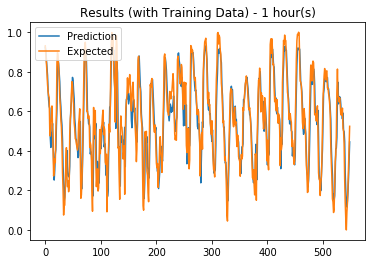

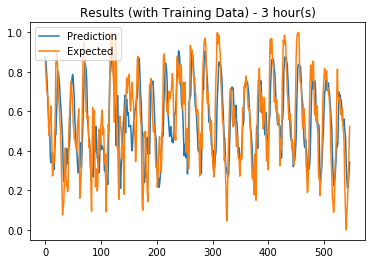

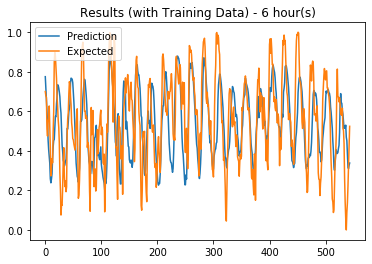

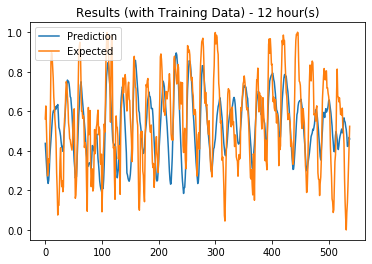

In [19]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_train, hour)
    _, expected_results = generate_Y(X_train_data, hour)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Training Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

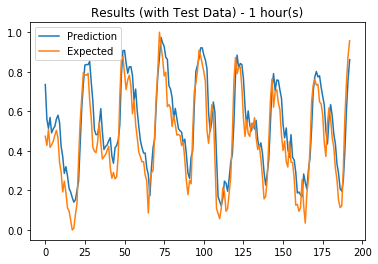

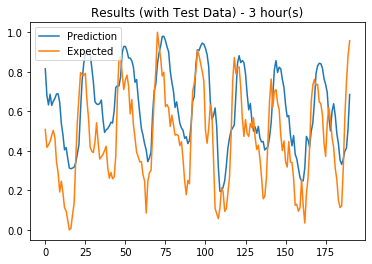

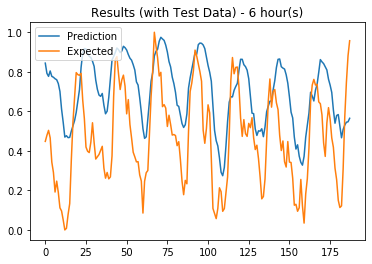

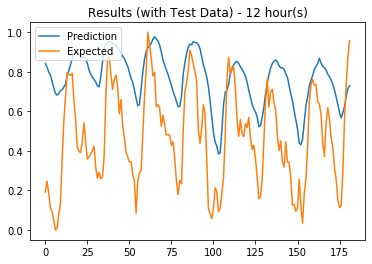

In [20]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_test, hour)
    _, expected_results = generate_Y(X_test_data, hour)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Test Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

In [21]:
table = [
    ["Metric",],
    ["MSE training",],
    ["MSE validation",],
    ["MAE training",],
    ["MAE validation",],
    #["R training",],
    #["R test",],
    #["R2 training",],
    #["R2 test",],
]
    
table[0].append("Value")
table[1].append(min(training_history.history['mse']))
table[2].append(min(training_history.history['val_mse']))
table[3].append(min(training_history.history['mae']))
table[4].append(min(training_history.history['val_mae']))
#table[5].append(training_history.history['r_train'][0])
#table[6].append(training_history.history['r_test'][0])
#table[7].append(training_history.history['r2_train'])
#table[8].append(training_history.history['r2_test'])
    
display(HTML(tabulate.tabulate(table, tablefmt="html", headers="firstrow")))

Metric,Value
MSE training,0.0080286
MSE validation,0.0114905
MAE training,0.0702675
MAE validation,0.0907079
